# Model Evaluation

The purpose of this notebook is to evaluate the ModernBert Baseline and CDA models on the Bias in Bios test dataset. Then, we will compare the differences in predicted professions for males and females to see if training the model on the counterfactual augmented data reduced bias towards predicting certain professions for bios with female gendered terms versus bios with male gendered terms.

*Table of Contents*

>[Setup](#scrollTo=wGLPtxELcFLG)

> [Functions](#scrollTo=VCWkdkjrwc5H)

>[Baseline evaluation](#scrollTo=TU4YLU04cIYS)

>[CDA evaluation](#scrollTo=E_BwfxijcKYa)

>[Compare Results](#scrollTo=h1f4EP8scMyo)

**Conclusion:**

The model trained on counterfactually augmented data is able to retain an overall accuracy of 86.16%, achieving only a slightly higher accuracy than the basline evaluation at 85.9%.

The baseline model produces an F1 macro of 0.803 when predicting the professions of females, and 0.7821 when predicting the professions of males.

The CDA model produces an F1 macro of 0.8006 when predicting professions of females, and 0.7839 when predicting the professions of males.

By visually comparing the gap in true positive rates for males and females, we can see that the CDA model significantly reduced the gap, sometimes by over half for stereotypically gendered roles such as paralegal, yoga teacher, and rapper. However, certain professions such as model and surgeon did not experience a decrease in the TPR gap. Some professions like architect and poet actually increased the TPR gap in the CDA model.

The results suggest that while counterfactual data augmentation can show promising reductions in gender disparities with relatively low cost, modern transformer models still require stronger debiasing methods to fully remove true positive gaps.

## Setup

In [1]:
# Install dependencies
!pip install -q datasets
!pip install -q transformers

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial

from datasets import load_from_disk
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [3]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab-Notebooks/jordan-cda'

Mounted at /content/drive


In [4]:
# Load tokenized test data
mbert_test_inputs = load_from_disk(path + '/data_tokenized_inputs/mbert_test_inputs')

In [5]:
# Confirm load
print(mbert_test_inputs) # should have 99069 samples and 5 columns

Dataset({
    features: ['hard_text', 'labels', 'gender', 'input_ids', 'attention_mask'],
    num_rows: 99069
})


## Functions

In [6]:
num_classes = 28
BATCH_SIZE = 32

In [7]:
def compute_metrics(eval_pred, genders= None):
  """
  Computes evaluation metrics, including overall and gener-specific metrics.
  """
  preds, labels = eval_pred
  preds = np.argmax(preds, axis= 1)

  metrics = {
      'f1_macro': f1_score(labels, preds, average= 'macro'),
      'accuracy': accuracy_score(labels, preds),
      'conf_matrix_overall': confusion_matrix(labels, preds)
  }

  if genders is not None:
    for gender in np.unique(genders):
      mask = (genders == gender)
      cm = confusion_matrix(labels[mask], preds[mask])
      f1 = f1_score(labels[mask], preds[mask], average= 'macro')
      acc = accuracy_score(labels[mask], preds[mask])

      metrics[f'conf_matrix_{gender}'] = cm
      metrics[f'f1_{gender}'] = f1
      metrics[f'accuracy_{gender}'] = acc

  return metrics

In [8]:
# Map professions to their label
professions = ['accountant', 'architect','attorney','chiropractor','comedian',
               'composer','dentist','dietitian','dj','filmmaker',
               'interior_designer','journalist','model','nurse','painter',
               'paralegal','pastor','personal_trainer','photographer','physician',
               'poet','professor','psychologist','rapper','software_engineer',
               'surgeon','teacher','yoga_teacher']

profession_map = {num:prof for num, prof in enumerate(professions)}

profession_map

{0: 'accountant',
 1: 'architect',
 2: 'attorney',
 3: 'chiropractor',
 4: 'comedian',
 5: 'composer',
 6: 'dentist',
 7: 'dietitian',
 8: 'dj',
 9: 'filmmaker',
 10: 'interior_designer',
 11: 'journalist',
 12: 'model',
 13: 'nurse',
 14: 'painter',
 15: 'paralegal',
 16: 'pastor',
 17: 'personal_trainer',
 18: 'photographer',
 19: 'physician',
 20: 'poet',
 21: 'professor',
 22: 'psychologist',
 23: 'rapper',
 24: 'software_engineer',
 25: 'surgeon',
 26: 'teacher',
 27: 'yoga_teacher'}

In [9]:
def plot_conf_matrix(conf_matrix, title):
  '''
  Function to plot confusion matrix output
  '''
  plt.figure(figsize=(10,8))
  sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues',
              xticklabels=profession_map.values(),
              yticklabels=profession_map.values(), cbar=False, square=True)

  plt.title(title)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.tight_layout()

  return plt.show()

## Baseline evaluation

In [10]:
# Load baseline model
mbert_baseline = AutoModelForSequenceClassification.from_pretrained(path + '/models_trained/mbert_baseline', num_labels= num_classes)

In [11]:
baseline_training_args = TrainingArguments(
    output_dir= path + '/models_evaluation/mbert_baseline_test',
    eval_strategy= 'epoch',
    save_strategy= 'epoch',
    do_train= False,
    do_eval= True,
    per_device_eval_batch_size= BATCH_SIZE,
    report_to= 'none'
)

In [12]:
baseline_trainer = Trainer(
    model= mbert_baseline,
    args= baseline_training_args,
    eval_dataset= mbert_test_inputs,
    compute_metrics= partial(compute_metrics, genders= mbert_test_inputs['gender'])
)

In [13]:
baseline_results = baseline_trainer.evaluate()

/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
W1203 15:11:35.642000 326 torch/_inductor/utils.py:1558] [1/0_1] Not enough SMs to use max_autotune_gemm mode


In [14]:
print(f'Overall Accuracy: {round(baseline_results["eval_accuracy"]*100,2)}%\n',
      f'Accuracy- Males: {round(baseline_results['eval_accuracy_0']*100,2)}%\n',
      f'Accuracy-Females: {round(baseline_results['eval_accuracy_1']*100,2)}%\n',
      f'\n',
      f'Overall F1-Macro: {round(baseline_results['eval_f1_macro'],4)}\n',
      f'F1-Macro- Males: {round(baseline_results['eval_f1_0'],4)}\n',
      f'F1-Macro- Females: {round(baseline_results['eval_f1_1'],4)}')

Overall Accuracy: 85.9%
 Accuracy- Males: 85.4%
 Accuracy-Females: 86.48%
 
 Overall F1-Macro: 0.8138
 F1-Macro- Males: 0.7821
 F1-Macro- Females: 0.803


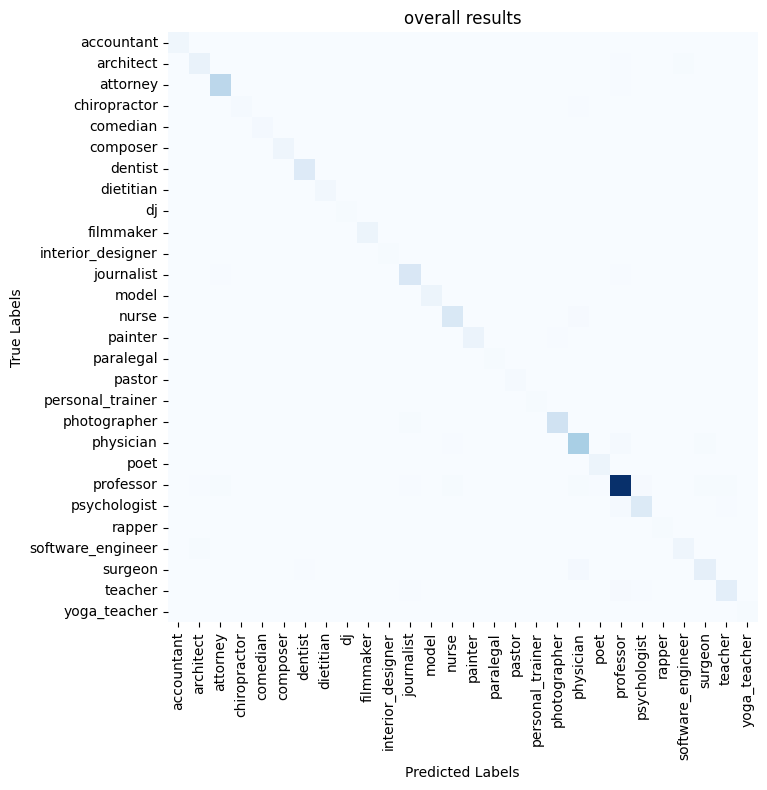

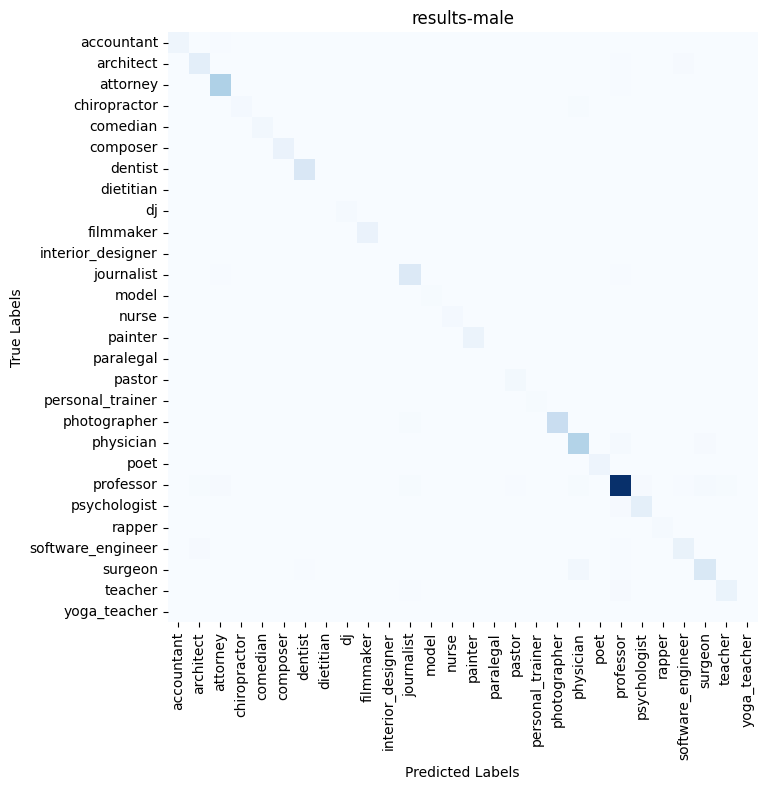

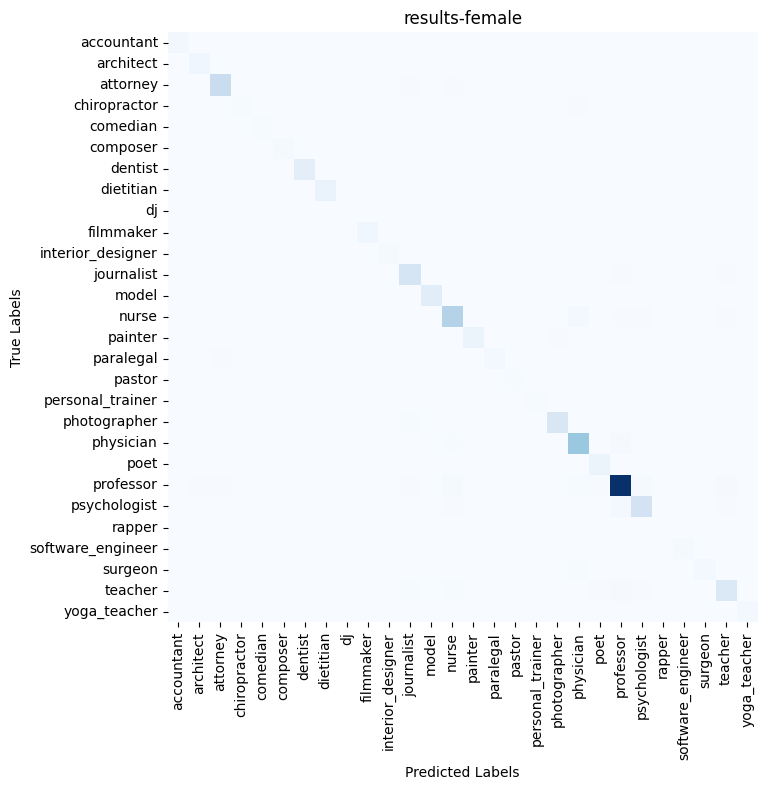

In [15]:
# Plot all confusion matrices for baseline evaluation
baseline_conf_matrices = {'overall results':baseline_results['eval_conf_matrix_overall'],
                 'results-male':baseline_results['eval_conf_matrix_0'],
                 'results-female':baseline_results['eval_conf_matrix_1']}

for title, matrix in baseline_conf_matrices.items():
  plot_conf_matrix(matrix, title)

In [19]:
# Save baseline test results to drive
torch.save(baseline_results, path + '/models_evaluation/baseline_test_results.pt')

In [ ]:
# Run this to reload baseline test results
baseline_results = torch.load(path + '/baseline_test_results.pt', weights_only=False)

In [17]:
# Confirm data reload
print(baseline_results)

{'eval_loss': 0.5035135746002197, 'eval_model_preparation_time': 0.0026, 'eval_f1_macro': 0.8138054261831945, 'eval_accuracy': 0.8590073585077067, 'eval_conf_matrix_overall': array([[ 1109,    30,    98,     1,     2,     2,     0,     3,     0,
            2,     1,    43,     7,    17,     2,     1,     4,     2,
           16,     5,     6,    20,     4,     0,     2,     2,    30,
            0],
       [   11,  1938,    37,     0,     1,     7,     0,     0,     1,
            3,    13,    38,    18,     4,    21,     0,     4,     1,
           26,     4,     9,   110,    13,     0,   235,     7,    26,
            1],
       [   64,    26,  7548,     2,     2,     5,     1,     3,     2,
            3,     0,    95,    16,    66,     0,    13,    19,     5,
           11,    19,    16,   114,    34,     1,     6,    12,    59,
            1],
       [    2,     1,     3,   429,     0,     0,    14,     2,     0,
            0,     0,     0,     2,     9,     2,     0,     1,    

## CDA evaluation

In [18]:
# Load CDA model
mbert_cda = AutoModelForSequenceClassification.from_pretrained(path + '/models_trained/mbert_cda', num_labels= num_classes)

In [20]:
cda_training_args = TrainingArguments(
    output_dir= path + '/models_evaluation/mbert_cda_test',
    eval_strategy= 'epoch',
    save_strategy= 'epoch',
    do_train= False,
    do_eval= True,
    per_device_eval_batch_size= BATCH_SIZE,
    report_to= 'none'
)

In [21]:
cda_trainer= Trainer(
    model= mbert_cda,
    args= cda_training_args,
    eval_dataset= mbert_test_inputs,
    compute_metrics= partial(compute_metrics, genders= mbert_test_inputs['gender'])
)

In [22]:
cda_results= cda_trainer.evaluate()

In [23]:
print(f'Overall Accuracy: {round(cda_results["eval_accuracy"]*100,2)}%\n',
      f'Accuracy- Males: {round(cda_results['eval_accuracy_0']*100,2)}%\n',
      f'Accuracy-Females: {round(cda_results['eval_accuracy_1']*100,2)}%\n',
      f'\n',
      f'Overall F1-Macro: {round(cda_results['eval_f1_macro'],4)}\n',
      f'F1-Macro- Males: {round(cda_results['eval_f1_0'],4)}\n',
      f'F1-Macro- Females: {round(cda_results['eval_f1_1'],4)}')

Overall Accuracy: 86.16%
 Accuracy- Males: 85.84%
 Accuracy-Females: 86.53%
 
 Overall F1-Macro: 0.8156
 F1-Macro- Males: 0.7839
 F1-Macro- Females: 0.8006


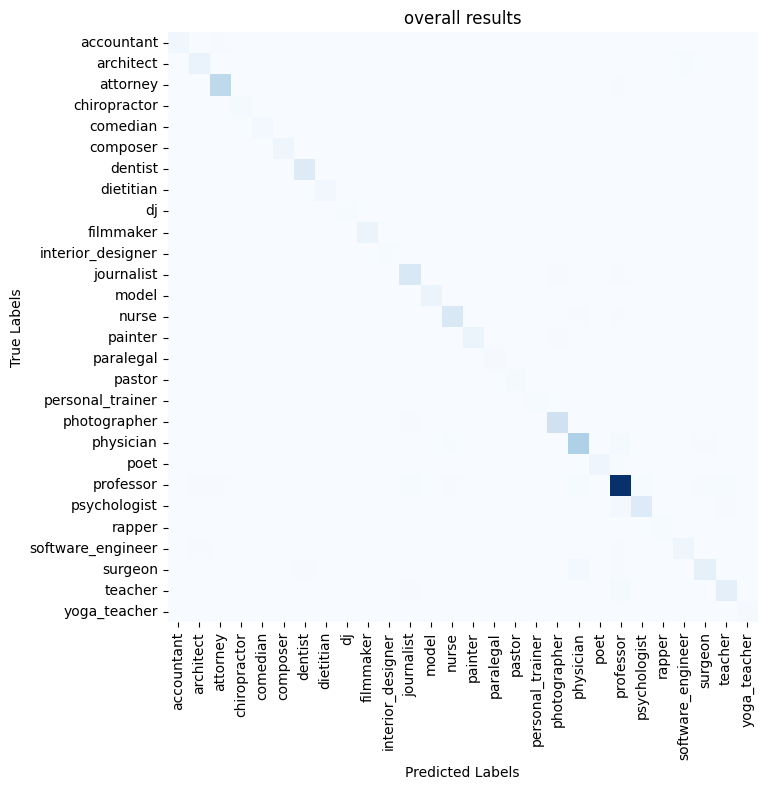

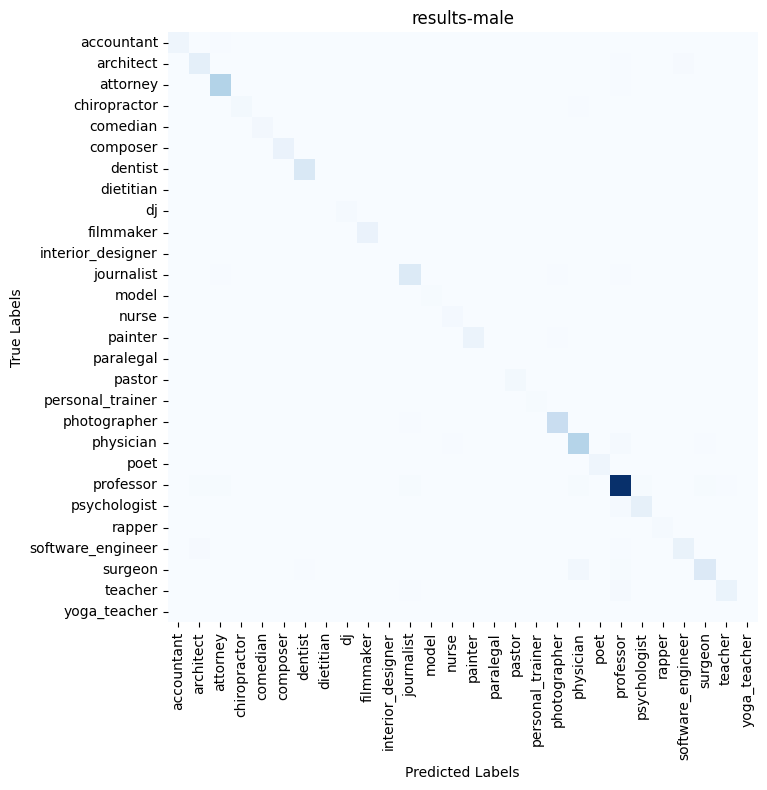

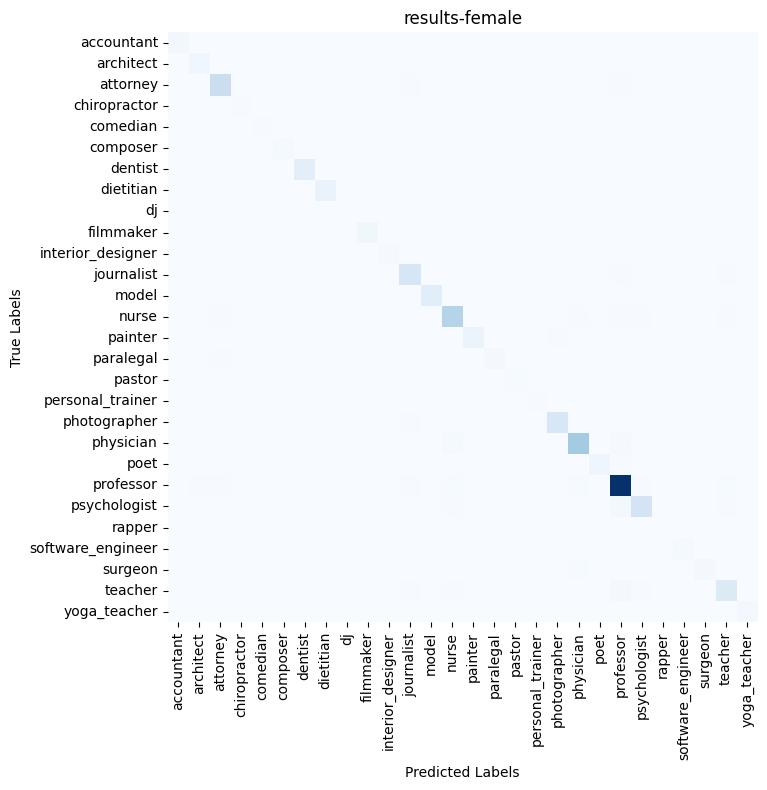

In [24]:
# Plot all confusion matrices for cda evaluation
cda_conf_matrices = {'overall results':cda_results['eval_conf_matrix_overall'],
                 'results-male':cda_results['eval_conf_matrix_0'],
                 'results-female':cda_results['eval_conf_matrix_1']}

for title, matrix in cda_conf_matrices.items():
  plot_conf_matrix(matrix, title)

In [25]:
# Save cda test results to drive
torch.save(cda_results, path + '/models_evaluation/cda_test_results.pt')

In [ ]:
# Run this to reload cda test results
cda_results = torch.load(path + '/cda_test_results.pt', weights_only=False)

In [ ]:
# Confirm data reload
print(cda_results)

{'eval_loss': 0.4899136424064636, 'eval_model_preparation_time': 0.0045, 'eval_f1_macro': 0.8152558248507835, 'eval_accuracy': 0.86122803298711, 'eval_conf_matrix_overall': array([[ 1106,    21,    94,     0,     2,     1,     2,     2,     0,
            2,     1,    46,     4,    12,     1,     4,     4,     3,
           12,     4,     4,    34,     6,     0,     3,     1,    40,
            0],
       [   18,  1911,    30,     0,     3,    12,     1,     0,     0,
            7,    28,    36,     5,     5,    28,     1,     3,     0,
           42,     2,     6,   106,     4,     0,   244,     5,    31,
            0],
       [   58,    19,  7532,     1,     4,     6,     2,     1,     1,
            2,     0,   107,    12,    31,     1,    30,    14,     6,
           17,    19,     9,   169,    31,     1,     7,     6,    56,
            1],
       [    2,     1,     2,   463,     0,     0,    10,     5,     0,
            0,     0,     1,     1,    15,     2,     0,     2,     1

## Compare Results

In [26]:
# Normalize gendered confusion matrices

cmnorm_fem_baseline = baseline_results['eval_conf_matrix_1'] / baseline_results['eval_conf_matrix_1'].sum(axis=1)
cmnorm_male_baseline = baseline_results['eval_conf_matrix_0'] / baseline_results['eval_conf_matrix_0'].sum(axis=1)

cmnorm_fem_cda = cda_results['eval_conf_matrix_1'] / cda_results['eval_conf_matrix_1'].sum(axis=1)
cmnorm_male_cda = cda_results['eval_conf_matrix_0'] / cda_results['eval_conf_matrix_0'].sum(axis=1)

In [27]:
# Ratio of true positives per gender and model
tp_fem_baseline = np.diag(cmnorm_fem_baseline)
tp_male_baseline = np.diag(cmnorm_male_baseline)

tp_fem_cda = np.diag(cmnorm_fem_cda)
tp_male_cda = np.diag(cmnorm_male_cda)

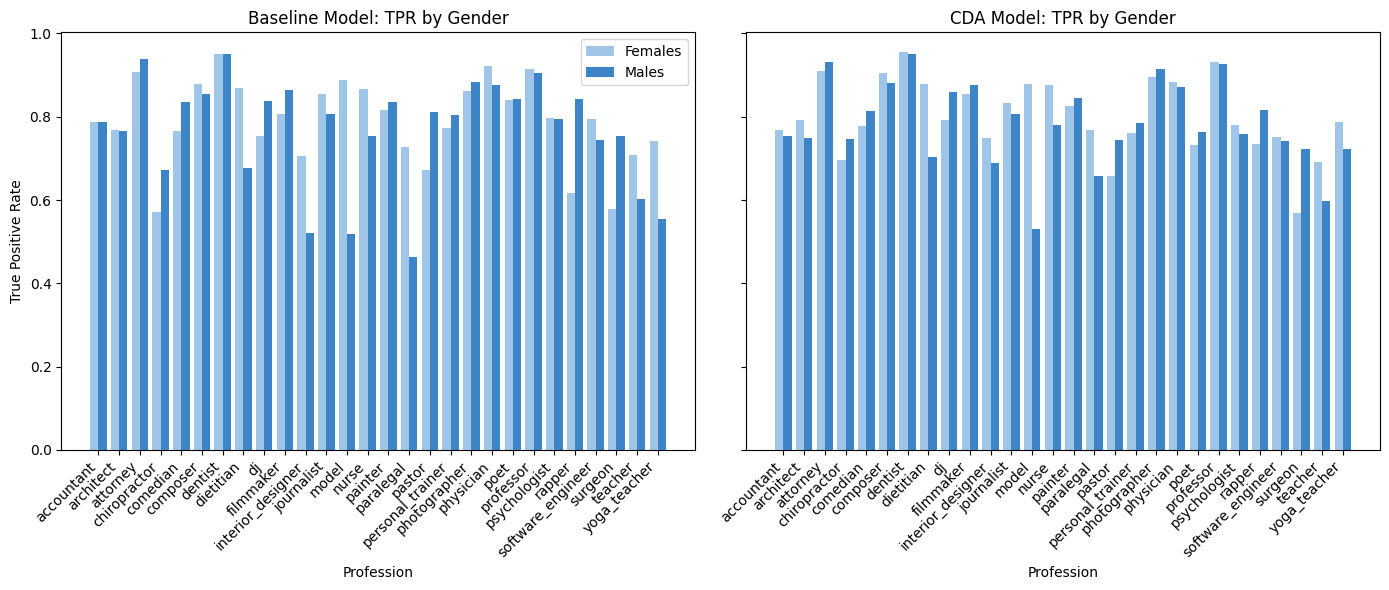

In [36]:
# Plot bar charts for true positives by gender (both models)
w = 0.4
x = np.arange(len(professions))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# ---- Panel A: Baseline ----
ax = axes[0]
ax.bar(x - w/2, tp_fem_baseline, width=w, label='Females', color = '#9fc5e8')
ax.bar(x + w/2, tp_male_baseline, width=w, label='Males', color = '#3d85c6')

ax.set_xticks(x)
ax.set_xticklabels(professions, rotation=45, ha='right')
ax.set_xlabel('Profession')
ax.set_ylabel('True Positive Rate')
ax.set_title('Baseline Model: TPR by Gender')
ax.legend()

# ---- Panel B: Fine-tuned ----
ax = axes[1]
ax.bar(x - w/2, tp_fem_cda, width=w, label='Females', color = '#9fc5e8')
ax.bar(x + w/2, tp_male_cda, width=w, label='Males', color = '#3d85c6')

ax.set_xticks(x)
ax.set_xticklabels(professions, rotation=45, ha='right')
ax.set_xlabel('Profession')
ax.set_title('CDA Model: TPR by Gender')

plt.tight_layout()
plt.show()

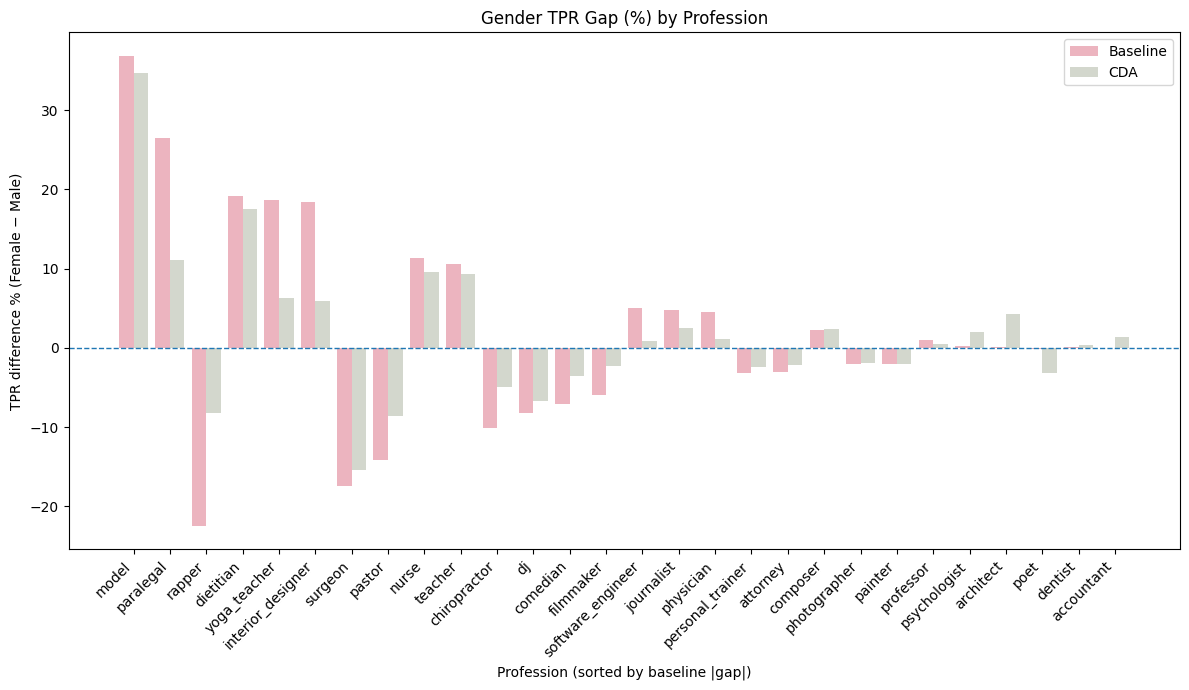

In [35]:
# Compute gender gaps
gap_base = (tp_fem_baseline - tp_male_baseline) * 100
gap_ft   = (tp_fem_cda   - tp_male_cda) * 100

gap_df = pd.DataFrame({
    'Profession': professions,
    'Baseline': gap_base,
    'CDA': gap_ft
})

# ---- SORT by absolute baseline gap (largest -> smallest) ----
gap_df_sorted = gap_df.reindex(
    gap_df['Baseline'].abs().sort_values(ascending=False).index
).reset_index(drop=True)

# Extract sorted values
prof_sorted   = gap_df_sorted['Profession']
gap_base_s    = gap_df_sorted['Baseline'].values
gap_ft_s      = gap_df_sorted['CDA'].values

# ---- Plot ----
x = np.arange(len(prof_sorted))
w = 0.4

fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(x - w/2, gap_base_s, width=w, label='Baseline', color= '#ecb4bf')
ax.bar(x + w/2, gap_ft_s,   width=w, label='CDA', color= '#d3d7cd')

ax.axhline(0.0, linestyle='--', linewidth=1)

ax.set_xticks(x)
ax.set_xticklabels(prof_sorted, rotation=45, ha='right')
ax.set_xlabel('Profession (sorted by baseline |gap|)')
ax.set_ylabel('TPR difference % (Female − Male)')
ax.set_title('Gender TPR Gap (%) by Profession')
ax.legend()

plt.tight_layout()
plt.show()
